本次以英雄联盟对局胜负预测任务为基础，要求实现决策树算法相关细节，加深对算法的理解，并了解做机器学习任务的大致流程。

### 任务介绍
英雄联盟（League of Legends，LoL）是一个多人在线竞技游戏，由拳头游戏（Riot Games）公司出品。在游戏中，每位玩家控制一位有独特技能的英雄，红蓝两支队伍各有五位玩家进行对战，目标是摧毁对方的基地水晶。水晶有多座防御塔保护，通常需要先摧毁一些防御塔再摧毁水晶。玩家所控制的英雄起初非常弱，需要不断击杀小兵、野怪和对方英雄来获得金币、经验。经验可以提升英雄等级和技能等级，金币可以用来购买装备提升攻击、防御等属性。对战过程中一般没有己方单位在附近的地点是没有视野的，即无法看到对面单位，双方可以通过使用守卫来监视某个地点，洞察对面走向、制定战术。
本数据集来自[Kaggle](https://www.kaggle.com/bobbyscience/league-of-legends-diamond-ranked-games-10-min)，包含了9879场钻一到大师段位的单双排对局，对局双方几乎是同一水平。每条数据是前10分钟的对局情况，每支队伍有19个特征，红蓝双方共38个特征。这些特征包括英雄击杀、死亡，金钱、经验、等级情况等等。一局游戏一般会持续30至40分钟，但是实际前10分钟的局面很大程度上影响了之后胜负的走向。作为最成功的电子竞技游戏之一，对局数据、选手数据的量化与研究具有重要意义，可以启发游戏将来的发展和改进。

本任务是希望同学们依据注释的要求，对代码中空缺部分进行填写，**完成决策树模型的详细实现**，根据已有的对局前10分钟特征信息，预测最后获胜方是蓝色方还是红色方，了解执行一个**机器学习任务的大致流程**，并**提交代码和实验报告**。第一次作业也是一个机器学习小实验的例子，之后的作业可能不再提供预处理等流程代码，由同学们自己设计实验完成代码编写。

### 导入工具包
pandas是数据分析和处理常用的工具包，非常适合处理行列表格数据。numpy是数学运算工具包，支持高效的矩阵、向量运算。sklearn是机器学习常用工具包，包括了一些已经实现好的简单模型和一些常用数据处理方法、评价指标等函数。

In [1]:
from collections import Counter
import pandas as pd # 数据处理
import numpy as np # 数学运算
from sklearn.model_selection import train_test_split, cross_validate # 划分数据集函数
from sklearn.metrics import accuracy_score # 准确率函数
RANDOM_SEED = 2020 # 固定随机种子
import copy

### 读入数据
假设数据文件放在`./data/`目录下，标准的csv文件可以用pandas里的`read_csv()`函数直接读入。文件共有40列，38个特征（红蓝方各19），1个标签列（blueWins），和一个对局标号（gameId）。对局标号不是标签也不是特征，可以舍去。

In [2]:
csv_data = './data/high_diamond_ranked_10min.csv' # 数据路径
data_df = pd.read_csv(csv_data, sep=',') # 读入csv文件为pandas的DataFrame
data_df = data_df.drop(columns='gameId') # 舍去对局标号列

###  数据概览
对于一个机器学习问题，在拿到任务和数据后，首先需要观察数据的情况，比如我们可以通过`.iloc[0]`取出数据的第一行并输出。不难看出每个特征都存成了float64浮点数，该对局蓝色方开局10分钟有小优势。同时也可以发现有些特征列是重复冗余的，比如blueGoldDiff表示蓝色队金币优势，redGoldDiff表示红色方金币优势，这两个特征是完全对称的互为相反数。blueCSPerMin是蓝色方每分钟击杀小兵数，它乘10就是10分钟所有小兵击杀数blueTotalMinionsKilled。在之后的特征处理过程中可以考虑去除这些冗余特征。
另外，pandas有非常方便的`describe()`函数，可以直接通过DataFrame进行调用，可以展示每一列数据的一些统计信息，对数据分布情况有大致了解，比如blueKills蓝色方击杀英雄数在前十分钟的平均数是6.14、方差为2.93，中位数是6，百分之五十以上的对局中该特征在4-8之间，等等。

In [3]:
print(data_df.iloc[0]) # 输出第一行数据
data_df.describe() # 每列特征的简单统计信息

blueWins                            0.0
blueWardsPlaced                    28.0
blueWardsDestroyed                  2.0
blueFirstBlood                      1.0
blueKills                           9.0
blueDeaths                          6.0
blueAssists                        11.0
blueEliteMonsters                   0.0
blueDragons                         0.0
blueHeralds                         0.0
blueTowersDestroyed                 0.0
blueTotalGold                   17210.0
blueAvgLevel                        6.6
blueTotalExperience             17039.0
blueTotalMinionsKilled            195.0
blueTotalJungleMinionsKilled       36.0
blueGoldDiff                      643.0
blueExperienceDiff                 -8.0
blueCSPerMin                       19.5
blueGoldPerMin                   1721.0
redWardsPlaced                     15.0
redWardsDestroyed                   6.0
redFirstBlood                       0.0
redKills                            6.0
redDeaths                           9.0


,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
count,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,...,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000
mean,0.499038,22.288288,2.824881,0.504808,6.183925,6.137666,6.645106,0.549954,0.361980,0.187974,...,0.043021,16489.041401,6.925316,17961.730438,217.349226,51.313088,-14.414111,33.620306,21.734923,1648.904140
std,0.500024,18.019177,2.174998,0.500002,3.011028,2.933818,4.064520,0.625527,0.480597,0.390712,...,0.216900,1490.888406,0.305311,1198.583912,21.911668,10.027885,2453.349179,1920.370438,2.191167,149.088841
min,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,11212.000000,4.800000,10465.000000,107.000000,4.000000,-11467.000000,-8348.000000,10.700000,1121.200000
25%,0.000000,14.000000,1.000000,0.000000,4.000000,4.000000,4.000000,0.000000,0.000000,0.000000,...,0.000000,15427.500000,6.800000,17209.500000,203.000000,44.000000,-1596.000000,-1212.000000,20.300000,1542.750000
50%,0.000000,16.000000,3.000000,1.000000,6.000000,6.000000,6.000000,0.000000,0.000000,0.000000,...,0.000000,16378.000000,7.000000,17974.000000,218.000000,51.000000,-14.000000,28.000000,21.800000,1637.800000
75%,1.000000,20.000000,4.000000,1.000000,8.000000,8.000000,9.000000,1.000000,1.000000,0.000000,...,0.000000,17418.500000,7.200000,18764.500000,233.000000,57.000000,1585.500000,1290.500000,23.300000,1741.850000
max,1.000000,250.000000,27.000000,1.000000,22.000000,22.000000,29.000000,2.000000,1.000000,1.000000,...,2.000000,22732.000000,8.200000,22269.000000,289.000000,92.000000,10830.000000,9333.000000,28.900000,2273.200000


### 增删特征
传统的机器学习模型大部分都是基于特征的，因此特征工程是机器学习中非常重要的一步。有时构造一个好的特征比改进一个模型带来的提升更大。这里简单展示一些特征处理的例子。首先，上面提到，特征列中有些特征信息是完全冗余的，会给模型带来不必要的计算量，可以去除。其次，相比于红蓝双方击杀、助攻的绝对值，可能双方击杀英雄的差值更能体现出当前对战的局势。因此，我们可以构造红蓝双方对应特征的差值。数据文件中已有的差值是金币差GoldDiff和经验差ExperienceDiff，实际上每个对应特征都可以构造这样的差值特征。

In [4]:
drop_features = ['blueGoldDiff', 'redGoldDiff', 
                 'blueExperienceDiff', 'redExperienceDiff', 
                 'blueCSPerMin', 'redCSPerMin', 
                 'blueGoldPerMin', 'redGoldPerMin'] # 需要舍去的特征列
df = data_df.drop(columns=drop_features) # 舍去特征列
info_names = [c[3:] for c in df.columns if c.startswith('red')] # 取出要作差值的特征名字（除去red前缀）
for info in info_names: # 对于每个特征名字
    df['br' + info] = df['blue' + info] - df['red' + info] # 构造一个新的特征，由蓝色特征减去红色特征，前缀为br
# 其中FirstBlood为首次击杀最多有一只队伍能获得，brFirstBlood=1为蓝，0为没有产生，-1为红
df = df.drop(columns=['blueFirstBlood', 'redFirstBlood','redKills','redDeaths']) # 原有的FirstBlood, 一方的kills/deaths可删除

In [5]:
df.describe()
df['brFirstBlood']

0       1
1      -1
2      -1
3      -1
4      -1
       ..
9874    1
9875   -1
9876   -1
9877    1
9878    1
Name: brFirstBlood, Length: 9879, dtype: int64

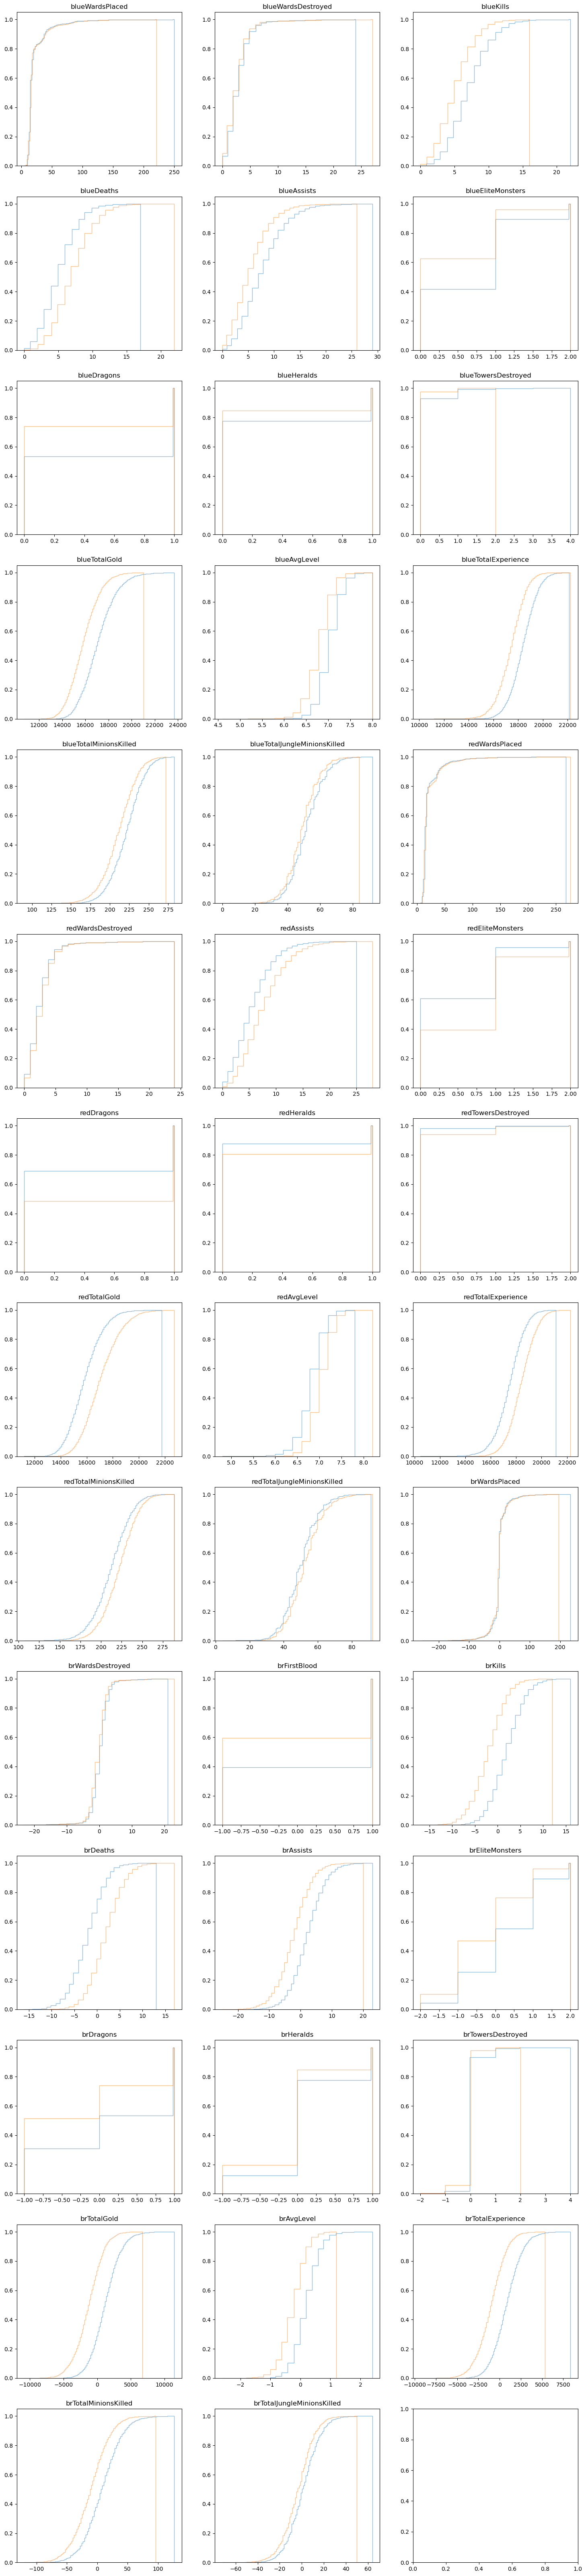

In [6]:
#plot hists to discover the relecance of feature to label 

import matplotlib.pyplot as plt

figure, axes = plt.subplots(14, 3, figsize = (18, 84), dpi = 100)
ax = axes.flatten() 
for i, c in enumerate(df.columns[1:]):
    ax[i].hist(df.loc[df['blueWins'] == 1][c], bins = 100, alpha = 0.5, histtype='step', cumulative = True,density=True)
    ax[i].hist(df.loc[df['blueWins'] == 0][c], bins = 100, alpha = 0.5, histtype='step', cumulative = True,density=True)
    ax[i].set_title(c)
    
#plt.savefig("beforeDiscrete.png") #保存作的图
plt.show()


In [7]:
#删除和标签关联性不明显的特征
df = df.drop(columns=['blueWardsPlaced', 'blueWardsDestroyed', 'blueTotalJungleMinionsKilled',
                      'redWardsPlaced', 'redWardsDestroyed', 'redTowersDestroyed', 
                      'redTotalJungleMinionsKilled', 'brWardsPlaced'])

### 特征离散化
决策树ID3算法一般是基于离散特征的，本例中存在很多连续的数值特征，例如队伍金币。直接应用该算法每个值当作一个该特征的一个取值可能造成严重的过拟合，因此需要对特征进行离散化，即将一定范围内的值映射成一个值，例如对用户年龄特征，将0-10映射到0，11-18映射到1，19-25映射到2，25-30映射到3，等等类似，然后在决策树构建时使用映射后的值计算信息增益。

***本小节要求实现特征离散化，请补全相关代码***

In [8]:
#看看现在还剩几个特征
feature_names = df.columns[1:]
len(feature_names)

33

In [9]:
midclass = 7 #可调参数：除了两边极值外，中间分几份

def discretedf(df, num, choice):
    discrete_df = df.copy() # 先复制一份数据
    discrete_df2 = df.copy() #再复制一份数据，使用另一种方式进行离散化    
    '''
        请离散化每一列特征，即discrete_df[c] = ...

        提示：
        对于有些特征本身取值就很少，可以跳过即 if ... : continue
        对于其他特征，可以使用等区间离散化、等密度离散化或一些其他离散化方法
        可参考使用pandas.cut或qcut
    '''

    for c in df.columns[1:]: # 遍历每一列特征，跳过标签列

        if c == 'brFirstBlood':continue
        if c == 'blueEliteMonsters' or c == 'blueDragons' or c == 'blueHeralds' or c == 'blueTowersDestroyed': continue
        if c == 'redEliteMonsters' or c == 'redDragons' or c == 'redHeralds' or c == 'redTowersDestroyed': continue
        if c == 'brEliteMonsters' or c == 'brDragons' or c == 'brHeralds' or c == 'brTowersDestroyed': continue

        #离散方法1：去极值后按x值等区间划分
        win_l = df.loc[df['blueWins'] == 1][c].tolist()
        lose_l = df.loc[df['blueWins'] == 0][c].tolist()
        win_l.sort()
        lose_l.sort()
        lowerbound = win_l[int(0.01 * len(win_l))]
        upperbound = lose_l[int(0.99 * len(lose_l))]
        step = int((upperbound - lowerbound) * 1000 /num) #可调参数：分成几个区间
        bins = [ -np.inf] + [ i/1000 for i in list(range(int(lowerbound*1000), int(upperbound*1000), step))] + [upperbound, np.inf]
        discrete_df[c] = pd.cut(discrete_df[c],bins, labels = False)

        #离散方法2：等比划分    
        listl = df[c].tolist()
        listl.sort()
        lower = listl[int(0.01 * len(listl))]
        upper = listl[int(0.99 * len(listl))]
        bins = [-np.inf, lower, upper, np.inf]
        for i in range(1,num):
            new = listl[int((i/num)*len(listl))]
            bins.append(new)
        bins = set(bins)
        bins = list(bins)
        bins.sort()
        discrete_df2[c] = pd.cut(discrete_df2[c],bins, labels = False)
        
    if choice == 1: return discrete_df
    if choice == 2: return discrete_df2

discrete_df = discretedf(df, num = midclass, choice = 1)
discrete_df2 = discretedf(df, num = midclass, choice = 2)

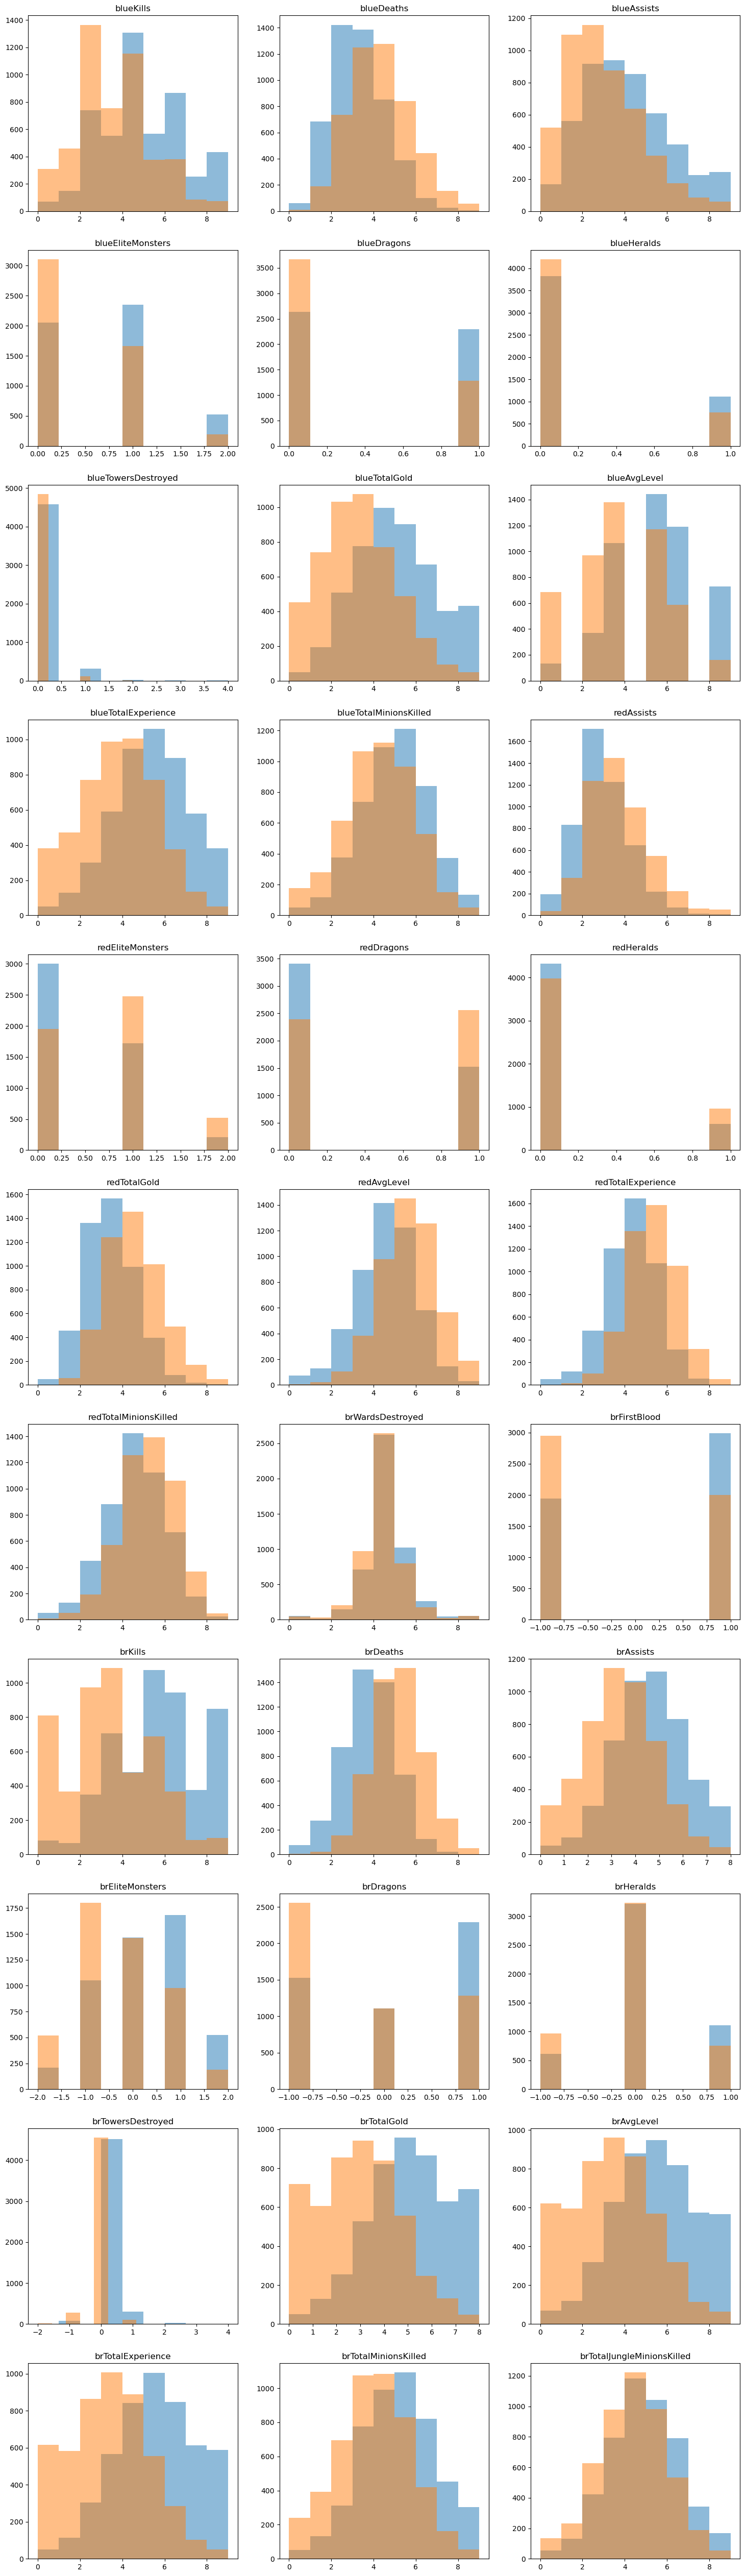

In [10]:
#再画一次图，看一看等区间离散效果
nob = midclass + 2
figure, axes = plt.subplots(11, 3, figsize = (18, 66), dpi = 100)
ax = axes.flatten() 
for i, c in enumerate(discrete_df.columns[1:]):
    ax[i].hist(discrete_df.loc[df['blueWins'] == 1][c], bins = nob, alpha = 0.5)#, histtype='step', cumulative = True,density=True)
    ax[i].hist(discrete_df.loc[df['blueWins'] == 0][c], bins = nob, alpha = 0.5)#, histtype='step', cumulative = True,density=True)
    ax[i].set_title(c)
    
#plt.savefig("afterDiscrete1_2.png") #保存作的图
plt.show()

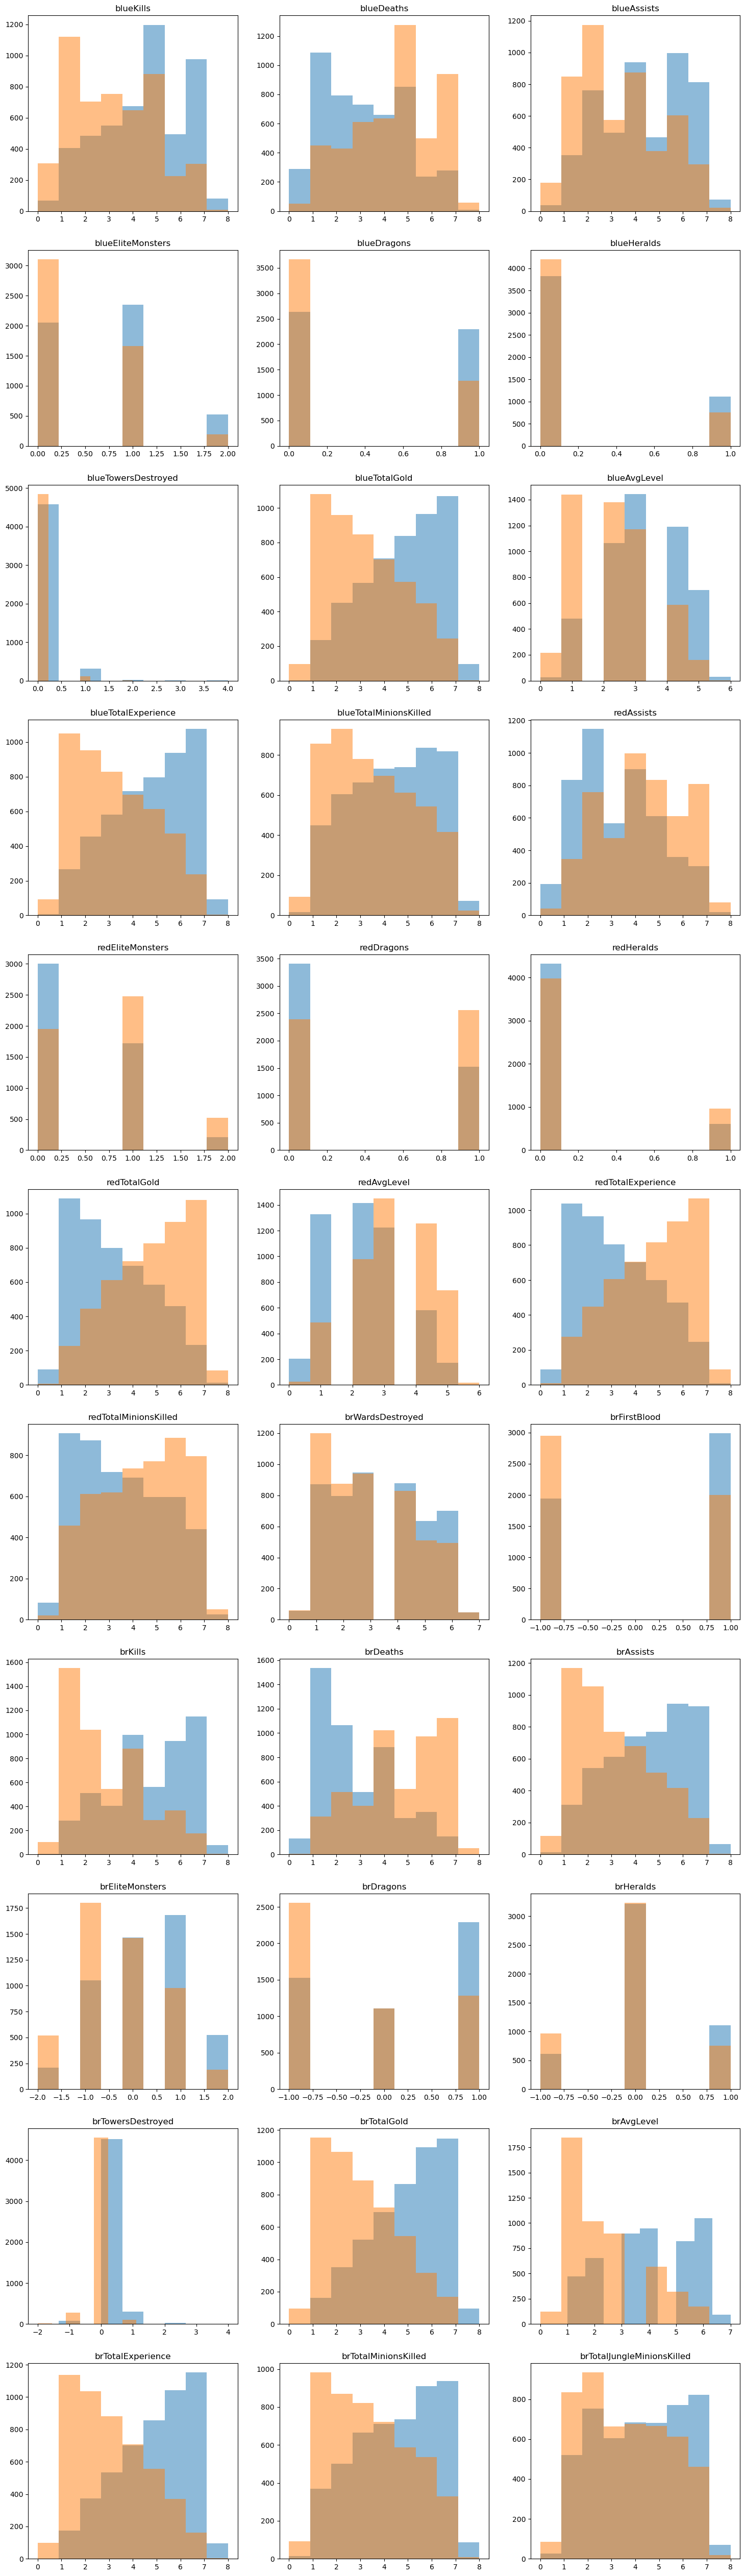

In [11]:
#等比划分离散效果
figure, axes = plt.subplots(11, 3, figsize = (18, 66), dpi = 100)
ax = axes.flatten() 
for i, c in enumerate(discrete_df2.columns[1:]):
    ax[i].hist(discrete_df2.loc[df['blueWins'] == 1][c], bins = nob, alpha = 0.5)#, histtype='step', cumulative = True,density=True)
    ax[i].hist(discrete_df2.loc[df['blueWins'] == 0][c], bins = nob, alpha = 0.5)#, histtype='step', cumulative = True,density=True)
    ax[i].set_title(c)
    
#plt.savefig("afterDiscrete2_2.png") #保存作的图
plt.show()

In [12]:
#discrete_df = discrete_df2 #选择用discrete_df还是discrete_df2
#print(discrete_df.head(5), df.head(5))
discrete_df.describe()

,blueWins,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,...,brAssists,brEliteMonsters,brDragons,brHeralds,brTowersDestroyed,brTotalGold,brAvgLevel,brTotalExperience,brTotalMinionsKilled,brTotalJungleMinionsKilled
count,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,...,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000
mean,0.499038,3.789655,3.321186,3.067922,0.549954,0.361980,0.187974,0.051422,3.734690,4.154368,...,3.996356,-0.023180,-0.051119,0.027938,0.008402,4.002733,3.998583,4.050815,4.141310,4.161352
std,0.500024,2.024623,1.494536,2.017875,0.625527,0.480597,0.390712,0.244369,2.141663,2.168578,...,1.857602,1.067934,0.878945,0.589292,0.324835,2.239753,2.246817,2.286002,1.912299,1.720698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-2.000000,-1.000000,-1.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,...,3.000000,-1.000000,-1.000000,0.000000,0.000000,2.000000,2.000000,2.000000,3.000000,3.000000
50%,0.000000,4.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,4.000000,5.000000,...,4.000000,0.000000,0.000000,0.000000,0.000000,4.000000,4.000000,4.000000,4.000000,4.000000
75%,1.000000,5.000000,4.000000,4.000000,1.000000,1.000000,0.000000,0.000000,5.000000,6.000000,...,5.000000,1.000000,1.000000,0.000000,0.000000,6.000000,5.000000,6.000000,5.000000,5.000000
max,1.000000,9.000000,9.000000,9.000000,2.000000,1.000000,1.000000,4.000000,9.000000,9.000000,...,8.000000,2.000000,1.000000,1.000000,4.000000,8.000000,9.000000,9.000000,9.000000,9.000000


### 数据集准备
构建机器学习模型前要构建训练和测试的数据集。在本例中首先需要分开标签和特征，标签是不能作为模型的输入特征的，就好比作业和试卷答案不能在做题和考试前就告诉学生。测试一个模型在一个任务上的效果至少需要训练集和测试集，训练集用来训练模型的参数，好比学生做作业获得知识，测试集用来测试模型效果，好比期末考试考察学生学习情况。测试集的样本不应该出现在训练集中，否则会造成模型效果估计偏高，好比考试时出的题如果是作业题中出现过的，会造成考试分数不能准确衡量学生的学习情况，估计值偏高。划分训练集和测试集有多种方法，下面首先介绍的是随机取一部分如20%作测试集，剩下作训练集。sklearn提供了相关工具函数`train_test_split`。sklearn的输入输出一般为numpy的array矩阵，需要先将pandas的DataFrame取出为numpy的array矩阵。

In [13]:
all_y = discrete_df['blueWins'].values # 所有标签数据
feature_names = discrete_df.columns[1:] # 所有特征的名称
all_x = discrete_df[feature_names].values # 所有原始特征值，pandas的DataFrame.values取出为numpy的array矩阵

# 划分训练集、验证集和测试集
x_train, x_test, y_train, y_test = train_test_split(all_x, all_y, test_size=0.2, random_state=RANDOM_SEED)
x_training, x_val, y_training, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = RANDOM_SEED)
all_y.shape, all_x.shape, x_train.shape, x_training.shape, x_val.shape, x_test.shape, y_train.shape, y_training.shape, y_val.shape, y_test.shape # 输出数据行列信息

((9879,),
 (9879, 33),
 (7903, 33),
 (7112, 33),
 (791, 33),
 (1976, 33),
 (7903,),
 (7112,),
 (791,),
 (1976,))

In [14]:
#增加的一些计算用函数
import random

#计算离散变量的权重(y是数组） （没有用到）
def cal_weight(y):
    unique_val = set(y) #去掉重复的离散数据
    m = len(y)
    for v in unique_val:
        yield v, sum(v==y)/m #用generator返回 取值，权值（概率）
    yield None, 0

#计算众数
def cal_mode(y):   
    counts = np.bincount(y)
    mod = np.argmax(counts)
    return mod

#返回y中1的概率 （经考量后没有使用）
def prob1(y):
    count1 = 0
    for i in y:
        if i == 1:
            count1 += 1
    prob = count1 / len(y)
    return prob


#根据概率返回1或0（经考量后没有使用）
def gety(prob):
    x = random.randint(0, 99)
    x0 = prob * 100
    if x < x0: return 1
    else: return 0

#为信息熵重新定义log2函数
def newlog2(x):
    if x <= 0:
        return 0
    else: return np.log2(x)

#计算信息熵 (y是数组，label)
def Ent(y):
    ent = 0
    for v, p in cal_weight(y):
        ent -= p*newlog2(p)
    return ent


#信息增益（x_i: 第i个特征，1*m ??? )
def Gain(x_i, y, ent):
    gain = ent
    for v, p in cal_weight(x_i):
        index = x_i == v
        gain -= p*Ent(y[index])
    return gain
    
#信息增益率
def Gain_Ratio(x_i, y, ent):
    gain = ent 
    splitInfo = 1e-9 #约为0？？
    for v, p in cal_weight(x_i, w):
        index = x_i == v #取值为v的索引
        gain -= p*Ent(y[index])
        splitInfo -= p*newlog2(p)
    return gain/splitInfo

#Gini
def Gini(y):
    gini = 1
    for v, p in cal_weight(y):
        gini -= p**2
    return gini

def Gini_index(x_i, y):
    gini_index = 0
    for v, p in cal_weight(x_i):
        index = x_i == v
        gini_index += p*Gini(y[index])
    return gini_index
    

###  决策树模型的实现
***本小节要求实现决策树模型，请补全算法代码***

In [15]:
# 定义决策树类

class DecisionTree(object):
    
    def __init__(self,  features, criterion = "bestgainratio", splitter = 'best', 
                 max_depth = 20, min_samples_split = 10):
        self.criterion = criterion
        self.splitter = splitter
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.features = features
    
    ''' 原本提供的 init
    def __init__(self, classes, features, 
                 max_depth=10, min_samples_split=10,
                 impurity_t='entropy'):
       
        传入一些可能用到的模型参数，也可能不会用到
        classes表示模型分类总共有几类
        features是每个特征的名字，也方便查询总的共特征数
        max_depth表示构建决策树时的最大深度
        min_samples_split表示构建决策树分裂节点时，如果到达该节点的样本数小于该值则不再分裂
        impurity_t表示计算混杂度（不纯度）的计算方式，例如entropy或gini
        
        self.classes = classes
        self.features = features
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.impurity_t = impurity_t
        self.root = None # 定义根节点，未训练时为空
       '''
        
    
    def bestgain(self, X, y):
        best_Index = -1  
        best_gain = -np.inf
        ent = Ent(y)
        for i in range(X.shape[1]):
            gain = Gain(X[:,i], y, ent)
            if gain > best_gain:
                best_gain = gain
                best_Index = i #信息增益最大的特征
        return best_Index
        
    def bestgainratio(self, X, y):
        n = X.shape[1]
        gain_arr = np.zeros(n)
        ent = Ent(y)
        for i in range(n):
            gain_arr[i] = Gain(X[:,i], y, ent)
        m_gain = np.mean(gain_arr) #平均增益
        best_Index = -1
        best_gain_ratio = -np.inf
        for i in range(n):
            if gain_arr[i] > m_gain:
                gain_ratio = Gain_Ratio(X[:, i], y, ent)
                if gain_ratio > best_gain_ratio:
                    best_gain_ratio = gain_ratio
                    best_Index = i #信息增益比最大的特征
        return best_Index
    
    def bestgini(self, X, y):
        best_Index = -1
        best_gini_index = np.inf
        for i in range(X.shape[1]):
            gini_index = Gini_index(X[:,i], y)
            if gini_index < best_gini_index:
                best_gini_index = gini_index
                best_Index = i #基尼指数最小的特征
        return best_Index
    
    def rand_(self, X, y):
        return np.random.choice(X.shape[1])
    
    
    #build the tree
    def build_(self, X, y, feat_lst, criterion):
        m, n = X.shape #样本，特征数量
        
        if len(set(y)) == 1: return y[0] #当y中只有一种label时，返回改标签
        
        #考虑pre pruning返回情况
        if prob1(y) > 0.85 : return 1 #当1的概率大于90%时，该节点为1
        if prob1(y) < 0.15: return 0 #当1的概率小于10%时，该节点为0
        
        #当样本数量小于等于min_samples_split， 或者特征数量小于等于总特征数-树的最大深度时，返回该节点的众数
        if m <= self.min_samples_split or n <= len(self.features) - self.max_depth : return cal_mode(y)      #prob修改的地方
        
        
        if n == 1: #当特征数量为1时，该节点的值为y中的众数
            node = {'#': feat_lst[0]} #节点，存储特征的索引
            x = X[:, 0]
            for val in set(x):
                node[val] = cal_mode(y[x==val])                                           #prob修改的地方
        else:
            best_Index = criterion(X, y)
            splitVal = set(X[:,best_Index]) #该特征的所有取值
            if len(splitVal)==1: 
                return cal_mode(y) #特征值都一样，返回频数最大的类别                           #prob修改的地方
            else:
                node = {'#':feat_lst[best_Index]} #结点，存储特征的索引
                index = list(range(n))
                index.pop(best_Index) #需要划分的特征index
                feat_l = feat_lst[:] #避免影响，前面的
                feat_l.pop(best_Index)
                for val in splitVal:
                    i_sample = X[:, best_Index] == val #子数据集
                    node[val] = self.build_(X[i_sample][:,index], y[i_sample], feat_l, criterion)
        return node
                    
        
        
    '''
    请实现决策树算法，使得fit函数和predict函数可以正常调用，跑通之后的测试代码，
    要求之后测试代码输出的准确率大于0.6。
    
    提示：
    可以定义额外一些函数，例如
    impurity()用来计算混杂度
    gain()调用impurity用来计算信息增益
    expand_node()训练时递归函数分裂节点，考虑不同情况
        1. 无需分裂 或 达到分裂阈值
        2. 调用gain()找到最佳分裂特征，递归调用expand_node
        3. 找不到有用的分裂特征
        fit函数调用该函数返回根节点
    traverse_node()预测时遍历节点，考虑不同情况
        1. 已经到达叶节点，则返回分类结果
        2. 该特征取值在训练集中未出现过
        3. 依据特征取值进入相应子节点，递归调用traverse_node
    当然也可以有其他实现方式。

    '''
    ''' 原本提供的fit
        
    def fit(self, feature, label):

        assert len(self.features) == len(feature[0]) # 输入数据的特征数目应该和模型定义时的特征数目相同

        训练模型
        feature为二维numpy（n*m）数组，每行表示一个样本，有m个特征
        label为一维numpy（n）数组，表示每个样本的分类标签
        
        提示：一种可能的实现方式为
        self.root = self.expand_node(feature, label, depth=1) # 从根节点开始分裂，模型记录根节点
        '''
    def fit(self, X, y):
        assert len(self.features) == len(X[0])# 输入数据的特征数目应该和模型定义时的特征数目相同
        #建树
        if self.splitter == 'best':
            if self.criterion == 'bestgain':
                self.tree = self.build_(X, y, list(range(X.shape[1])), self.bestgain)
            elif self.criterion == 'bestgainratio':
                self.tree = self.build_(X, y, list(range(X.shape[1])), self.bestgainratio)
            elif self.criterion == 'bestgini':
                self.tree = self.build_(X, y, list(range(X.shape[1])), self.bestgini)
            else: 
                raise('gini/gain/gainratio')
        else:
            self.tree = self.self.build_(X, y, list(range(X.shape[1])), self.rand_) #随便建一颗树
        return self
    
    def predict(self, X):
        #assert len(X.shape) == 1 or len(X.shape) == 2 # 只能是1维或2维
        if len(X.shape) > 1: #二维数组
            rst = np.zeros(X.shape[0])
            for i, x in enumerate(X):
                rst[i] = self.predict_(x)
                #rst[i] = gety(rst[i])                                 #prob修改的地方
        elif len(X) == 0:
            rst = -1
        else:
            rst = self.predict_(X)
            #rst = gety(rst)                                             #prob修改的地方
        return rst
    
    def predict_(self, x):
        tree = self.tree
        while True:
            if isinstance(tree, dict):
                key = tree['#'] #树的名字
            else:
                return tree
            try:
                tree = tree[x[key]] #根据取值进入下一级
            except:
                return -1
        '''
        预测
        输入feature可以是一个一维numpy数组也可以是一个二维numpy数组
        如果是一维numpy（m）数组则是一个样本，包含m个特征，返回一个类别值
        如果是二维numpy（n*m）数组则表示n个样本，每个样本包含m个特征，返回一个numpy一维数组
        
        提示：一种可能的实现方式为
        if len(feature.shape) == 1: # 如果是一个样本
            return self.traverse_node(self.root, feature) # 从根节点开始路由
        return np.array([self.traverse_node(self.root, f) for f in feature]) # 如果是很多个样本
        '''
    '''
    # 定义决策树模型，传入算法参数
    DT = DecisionTree(classes=[0,1], features=feature_names, max_depth=5, min_samples_split=10, impurity_t='gini')

    DT.fit(x_train, y_train) # 在训练集上训练
    p_test = DT.predict(x_test) # 在测试集上预测，获得预测值
    print(p_test) # 输出预测值
    test_acc = accuracy_score(p_test, y_test) # 将测试预测值与测试集标签对比获得准确率
    print('accuracy: {:.4f}'.format(test_acc)) # 输出准确率
    ''' 


In [16]:
#为后剪枝训练一个模型
DT = DecisionTree(criterion = "bestgini", splitter = 'best', features=feature_names, max_depth = 2, min_samples_split = 10)
DT.fit(x_training, y_training) #在训练集上训练 
p_val = DT.predict(x_val) #在测试集上预测，获得预测值
#print(p_val)
val_acc = accuracy_score(p_val, y_val)# 将测试预测值与测试集标签对比获得准确率
print('accuracy:{:.4f}'.format(val_acc))# 输出准确率

accuracy:0.7332


In [17]:
#看看树的样子
DT.tree

{'#': 28,
 0: 0,
 1: {'#': 7, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0},
 2: {'#': 25, 0: 0, 1: 0, -1: 0},
 3: {'#': 24, 0: 0, 1: 0, 2: 0, -2: 0, -1: 0},
 4: {'#': 24, 0: 1, 1: 1, 2: 1, -1: 0, -2: 0},
 5: {'#': 30, 2: 0, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 9: 1},
 6: {'#': 9, 0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 9: 1},
 7: {'#': 24, 0: 1, 1: 1, 2: 1, -2: 1, -1: 1},
 8: 1}

In [18]:
#后剪枝函数
#先准备一棵用来修改和预测的树
DTbusy = copy.deepcopy(DT)
#先定义一些函数
#返回在val上的准确率
def acc_val(dtree):
    DTbusy.tree = dtree #借用DTbusy进行测试
    p_val = DTbusy.predict(x_val) #在val集上预测，获得预测值                       
    val_acc = accuracy_score(p_val, y_val)
    return val_acc 

#return type: list of keys to locate the node
def nextnode(keys, tree): #keys: list, tree: dict
    newkeys = copy.deepcopy(keys)
    count = 0
    for value in tree.values():
        count += isinstance(value, int or float)
    if count == len(tree):
        return newkeys
    else: 
        for newkey, value in tree.items():
            if isinstance(value, int or float): pass
            if isinstance(value, dict):
                newkeys.append(newkey)
                return nextnode(newkeys, value)

def replacenode(keys, tree, k): #replace node with k
    depth = len(keys)
    for i in range(depth - 1):
        tree = tree[keys[i]]
    tree[keys[depth - 1]] = k


def postpruning(tree): #返回修剪好的树，类型为dict
    oldTree = copy.deepcopy(tree) #用来砍到没有子节点的树
    savedTree = copy.deepcopy(tree) #最优树
    saved_acc = acc_val(savedTree) #最优树的正确率

    keys = []
    keys = nextnode(keys, oldTree)
    counts = 0
    print(keys)

    while(len(keys) != 0):
        newTree = copy.deepcopy(savedTree) #复制一份最优树
        replacenode(keys, oldTree, 0)
        replacenode(keys, newTree, 0) #将节点换成0
        acc0 = acc_val(newTree)
        if  acc0 >= saved_acc:
            saved_acc = acc0
            savedTree = copy.deepcopy(newTree)
            counts += 1
            print("replace key:", keys, "   value: 0")
            print("accuracy:", saved_acc)
        replacenode(keys, newTree, 1) #将节点换成1
        acc1 = acc_val(newTree)
        if acc1 >= saved_acc:
            saved_acc = acc1
            savedTree = copy.deepcopy(newTree)
            counts += 1
            print("repalce keys:", keys, "   value: 1")
            print("accuracy:", saved_acc)
        
        keys = []
        keys = nextnode(keys, oldTree)
        print(keys)
        
    print("oldTree: ", oldTree)
    print("counts:", counts)
    return savedTree



In [19]:
DT2 = copy.deepcopy(DT)
p_val = DT2.predict(x_val) #在val集上预测，获得预测值
#print(p_val)
val_acc = accuracy_score(p_val, y_val)# 将val预测值与val集标签对比获得准确率
print('accuracy:{:.4f}'.format(val_acc))# 输出准确率
print(DT2.tree)

accuracy:0.7332
{'#': 28, 0: 0, 1: {'#': 7, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}, 2: {'#': 25, 0: 0, 1: 0, -1: 0}, 3: {'#': 24, 0: 0, 1: 0, 2: 0, -2: 0, -1: 0}, 4: {'#': 24, 0: 1, 1: 1, 2: 1, -1: 0, -2: 0}, 5: {'#': 30, 2: 0, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 9: 1}, 6: {'#': 9, 0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 9: 1}, 7: {'#': 24, 0: 1, 1: 1, 2: 1, -2: 1, -1: 1}, 8: 1}


In [20]:
#！！将上面打印出来的树手动复制下来 #我也不知道为什么不复制不能跑
DT2.tree = {'#': 28, 0: 0, 1: {'#': 7, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}, 2: {'#': 25, 0: 0, 1: 0, -1: 0}, 3: {'#': 24, 0: 0, 1: 0, 2: 0, -2: 0, -1: 0}, 4: {'#': 24, 0: 1, 1: 1, 2: 1, -1: 0, -2: 0}, 5: {'#': 30, 2: 0, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 9: 1}, 6: {'#': 9, 0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 9: 1}, 7: {'#': 24, 0: 1, 1: 1, 2: 1, -2: 1, -1: 1}, 8: 1}
#后剪枝
DT2.tree = postpruning(DT2.tree)
p_val2 = DT2.predict(x_val) #在val集上预测，获得预测值
val_acc = accuracy_score(p_val2, y_val)# 将val预测值与val集标签对比获得准确率
print('accuracy:{:.4f}'.format(val_acc))# 输出准确率


[1]
replace key: [1]    value: 0
accuracy: 0.7332490518331226
[2]
replace key: [2]    value: 0
accuracy: 0.7332490518331226
[3]
replace key: [3]    value: 0
accuracy: 0.7332490518331226
[4]
[5]
repalce keys: [5]    value: 1
accuracy: 0.7357774968394437
[6]
repalce keys: [6]    value: 1
accuracy: 0.7357774968394437
[7]
repalce keys: [7]    value: 1
accuracy: 0.7357774968394437
[]
oldTree:  {'#': 28, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 1}
counts: 6
accuracy:0.7358


In [21]:
p_test = DT2.predict(x_test) #在测试集上预测，获得预测值
print(p_test)
test_acc = accuracy_score(p_test, y_test)# 将测试预测值与测试集标签对比获得准确率
print('accuracy:{:.4f}'.format(test_acc))# 输出准确率

[0. 1. 0. ... 0. 1. 1.]
accuracy:0.7267


### 模型调优
第一次模型测试结果可能不够好，可以先检查调试代码是否有bug，再尝试调整参数或者优化计算方法。

In [22]:
#寻找最佳深度 这个模块可以跳过
depth = list(range(1, len(feature_names)))#用这个比较可靠，但根据经验，可以略减小树的深度
depth = list(range(1, 6)) #7112 / 7^6 = 0.06045个样本，已经非常可能过拟合了
acc1 = []
acc2 = []

for dep in depth:
    DT = DecisionTree(criterion = "bestgini", splitter = 'best',features=feature_names, max_depth = dep, min_samples_split = 10)
    DT.fit(x_training, y_training) #在训练集上训练 
    p_val = DT.predict(x_val) #在val集上预测，获得预测值
    val_acc1 = accuracy_score(p_val, y_val)# 将预测值与验证集标签对比获得准确率
    print('depth:', dep, ' accuracy:{:.4f}'.format(val_acc1))# 输出准确率
    acc1.append(val_acc1)   
    countinvalid = 0
    p_valnew = []
    for i in p_val:
        if i == 1:
            p_valnew.append(1)
        elif i == 0:
            p_valnew.append(0)
        else:
            countinvalid += 1
            p_valnew.append(0)
    val_acc2 = accuracy_score(p_valnew, y_val)# 将预测值与验证集标签对比获得准确率
    acc2.append(val_acc2)
    print('invalid', countinvalid, 'illusion accuracy:{:.4f}'.format(val_acc2))# 输出准确率

depth: 1  accuracy:0.7080
invalid 0 illusion accuracy:0.7080
depth: 2  accuracy:0.7332
invalid 0 illusion accuracy:0.7332
depth: 3  accuracy:0.6903
invalid 2 illusion accuracy:0.6915
depth: 4  accuracy:0.6662
invalid 12 illusion accuracy:0.6751
depth: 5  accuracy:0.6549
invalid 20 illusion accuracy:0.6688


[1, 2, 3, 4, 5]
[0.7079646017699115, 0.7332490518331226, 0.6902654867256637, 0.6662452591656132, 0.6548672566371682]
[0.7079646017699115, 0.7332490518331226, 0.6915297092288243, 0.6750948166877371, 0.6687737041719343]


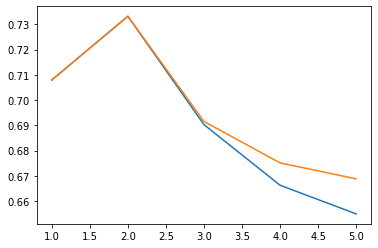

In [25]:
print(depth)
print(acc1)
print(acc2)

plt.plot(depth, acc1)
plt.plot(depth, acc2)
plt.show()

分析：
当深度大于2时，随着深度加深，无法判断的值（invalid）增多，accuracy降低。
但由于在验证集（791个样本）95%置信度的区间约为Accuracy+-0.03，accuracy降低得可能并不显著。
结论：
最优深度为2层（左右）。

In [24]:
#寻找最佳离散组数 这个模块可以跳过
i_s = []
val1 = []
val2 = []
for i in range(1, 25):
    midclass = i
    i_s.append(i)
    
    print('midclass:', midclass)
    #按要求离散特征
    discrete_df = discretedf(df, num = midclass, choice = 1)
    discrete_df2 = discretedf(df, num = midclass, choice = 2)
    
    #划分训练集、验证集和测试集
    all_y = discrete_df['blueWins'].values # 所有标签数据
    feature_names = discrete_df.columns[1:] # 所有特征的名称
    all_x = discrete_df[feature_names].values # 所有原始特征值，pandas的DataFrame.values取出为numpy的array矩阵
    x_train, x_test, y_train, y_test = train_test_split(all_x, all_y, test_size=0.2, random_state=RANDOM_SEED)
    x_training, x_val, y_training, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = RANDOM_SEED)
    all_y.shape, all_x.shape, x_train.shape, x_training.shape, x_val.shape, x_test.shape, y_train.shape, y_training.shape, y_val.shape, y_test.shape # 输出数据行列信息
    
    DT = DecisionTree(criterion = "bestgini", splitter = 'best', features=feature_names, max_depth = 2, min_samples_split = 10)
    DT.fit(x_training, y_training) #在训练集上训练 
    p_val = DT.predict(x_val) #在测试集上预测，获得预测值
    val_acc = accuracy_score(p_val, y_val)# 将测试预测值与测试集标签对比获得准确率
    val1.append(val_acc)
    print('method: 1 accuracy:{:.4f}'.format(val_acc))# 输出准确率
    
    
    #等比划分
    discrete_df = discrete_df2
    #划分训练集、验证集和测试集
    all_y = discrete_df['blueWins'].values # 所有标签数据
    feature_names = discrete_df.columns[1:] # 所有特征的名称
    all_x = discrete_df[feature_names].values # 所有原始特征值，pandas的DataFrame.values取出为numpy的array矩阵
    x_train, x_test, y_train, y_test = train_test_split(all_x, all_y, test_size=0.2, random_state=RANDOM_SEED)
    x_training, x_val, y_training, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = RANDOM_SEED)
    all_y.shape, all_x.shape, x_train.shape, x_training.shape, x_val.shape, x_test.shape, y_train.shape, y_training.shape, y_val.shape, y_test.shape # 输出数据行列信息
    
    DT = DecisionTree(criterion = "bestgini", splitter = 'best', features=feature_names, max_depth = 2, min_samples_split = 10)
    DT.fit(x_training, y_training) #在训练集上训练 
    p_val = DT.predict(x_val) #在测试集上预测，获得预测值
    val_acc = accuracy_score(p_val, y_val)# 将测试预测值与测试集标签对比获得准确率
    val2.append(val_acc)
    print('method 2 accuracy:{:.4f}'.format(val_acc))# 输出准确率
    

midclass: 1
method: 1 accuracy:0.6321
method 2 accuracy:0.6384
midclass: 2
method: 1 accuracy:0.7219
method 2 accuracy:0.7244
midclass: 3
method: 1 accuracy:0.6966
method 2 accuracy:0.7118
midclass: 4
method: 1 accuracy:0.7269
method 2 accuracy:0.7282
midclass: 5
method: 1 accuracy:0.7370
method 2 accuracy:0.7257
midclass: 6
method: 1 accuracy:0.7244
method 2 accuracy:0.7269
midclass: 7
method: 1 accuracy:0.7332
method 2 accuracy:0.7231
midclass: 8
method: 1 accuracy:0.7332
method 2 accuracy:0.7092
midclass: 9
method: 1 accuracy:0.7105
method 2 accuracy:0.7067
midclass: 10
method: 1 accuracy:0.7130
method 2 accuracy:0.7206
midclass: 11
method: 1 accuracy:0.6966
method 2 accuracy:0.7067
midclass: 12
method: 1 accuracy:0.7042
method 2 accuracy:0.7042
midclass: 13
method: 1 accuracy:0.6915
method 2 accuracy:0.7016
midclass: 14
method: 1 accuracy:0.7244
method 2 accuracy:0.7042
midclass: 15
method: 1 accuracy:0.7168
method 2 accuracy:0.7016
midclass: 16
method: 1 accuracy:0.7080
method 2 a

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
[0.6321112515802781, 0.7218710493046776, 0.6965865992414665, 0.7269279393173198, 0.7370417193426043, 0.7243994943109987, 0.7332490518331226, 0.7332490518331226, 0.7104930467762326, 0.7130214917825537, 0.6965865992414665, 0.7041719342604298, 0.6915297092288243, 0.7243994943109987, 0.7168141592920354, 0.7079646017699115, 0.7054361567635904, 0.7117572692793932, 0.7117572692793932, 0.6915297092288243, 0.7054361567635904, 0.6890012642225032, 0.695322376738306, 0.7003792667509482]
[0.638432364096081, 0.7243994943109987, 0.7117572692793932, 0.7281921618204804, 0.7256637168141593, 0.7269279393173198, 0.7231352718078382, 0.7092288242730721, 0.706700379266751, 0.7206068268015171, 0.706700379266751, 0.7041719342604298, 0.7016434892541087, 0.7041719342604298, 0.7016434892541087, 0.7041719342604298, 0.7117572692793932, 0.7054361567635904, 0.7029077117572693, 0.6927939317319848, 0.6864728192161821, 0.709228824273

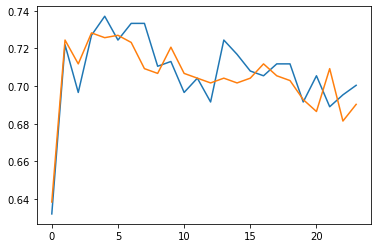

In [30]:
print(i_s)
print(val1)
print(val2)

plt.plot(val1)
plt.plot(val2)
plt.show()

x轴表示除了两个极值外的分界线数量k，实际组数为其+3）k = midclass -1
y轴表示accuracy。
蓝线等区间划分，橙线等比划分。
分析：
在验证集（791个样本）95%置信度的区间约为Accuracy+-0.03。
k = 0时，accuracy较低。
k > 1时，对着区间划分数量增多，accuracy呈下降趋势，但是并不显著。

In [29]:
#用别的criterion建树
DT = DecisionTree(criterion = "bestgain", splitter = 'best', features=feature_names, max_depth = 2, min_samples_split = 10)
DT.fit(x_training, y_training) #在训练集上训练 
p_val = DT.predict(x_val) #在测试集上预测，获得预测值
#print(p_val)
val_acc = accuracy_score(p_val, y_val)# 将测试预测值与测试集标签对比获得准确率
print('accuracy:{:.4f}'.format(val_acc))# 输出准确率

accuracy:0.7332


### 总结
一个完整的机器学习任务包括：确定任务、数据分析、特征工程、数据集划分、模型设计、模型训练和效果测试、结果分析和调优等多个阶段，本案例以英雄联盟游戏胜负预测任务为例，给出了每个阶段的一些简单例子，帮助大家入门机器学习，希望大家有所收获！

In [26]:
#最终测试
p_test = DT2.predict(x_test) #在测试集上预测，获得预测值
print(p_test)
test_acc = accuracy_score(p_test, y_test)# 将测试预测值与测试集标签对比获得准确率
print('accuracy:{:.4f}'.format(test_acc))# 输出准确率

[0. 1. 0. ... 0. 1. 1.]
accuracy:0.7267


In [27]:
#最终树的样子
DT2.tree

{'#': 28,
 0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: {'#': 24, 0: 1, 1: 1, 2: 1, -1: 0, -2: 0},
 5: 1,
 6: 1,
 7: 1,
 8: 1}

In [28]:
feature_names[28], feature_names[24]

('brTotalGold', 'brEliteMonsters')

结论：置信度为95%的置信区间为0.7267±0.0196。